# Two key concepts: Causality and Non-stationarity

Most ML tools fail to cover **causality** relationships between features and labels because they are mostly focused to capture *correlations*, which are weaker because they characterize a two-way relationship $(\textbf{X} \leftrightarrow \textbf{y})$, which causality specifies a direction $\textbf{X} \rightarrow \textbf{y}$ or $\textbf{X} \leftarrow \textbf{y}$.

A fashionable example is sentiment (and its relationship with returns). A high sentiment may increase the demand and push its price while returns may well cause sentiment. A long period of market return will probably result in the increasing sentiment. In Coqueret (2020), it is found (in opposition to most findings in this field), that the latter reshionship (returns $\rightarrow$ sentiment) is more likely and backed by causality driven tests (see Section 14.1.1).

Statistical causality is a large field and we refer to Pearl (2009) for a deeper discussion. Recently, researchers have sought to link causality with ML approaches (see, e.g., Peters et al. (2017), Heinze-Deml et al. (2018), Arjovsky et al. (2019)). The key notion in their work is **invariance**.

Often, data is collected not at once, but from different sources at different moments. Some relationships found in these different sources will change, while others may remain the same. The relationships that are **invariant to changing environments** are likely to stem from (and signal) causality. 

One counter-example is the following: training a CV algorithm to discriminate between cows and camels will lead the algorithm to focus on grass VS sand! This is because most camels are pictured in the desert while cows are shown in green fields of grass. Thus, a picture of a camel on grass will be classified as cow, while a cow on sand would be labelled “camel”. It is only with pictures of these two animals in *different contexts (environments)* that the learner will end up truly finding what makes a cow and a camel. The representation of the camel becomes invariant over all datasets and the learner has discovered causality, i.e., the true attributes that make the camel a camel (overall silhouette, shape of the back, face, color (possibly misleading!), etc.).

his search for invariance makes sense for many disciplines like CV and NLP. In finance, it is not obvious that invariance may exist. Market conditions are known to be time-varying and the relationships between firm characteristics and returns also change from year to year. One solution to this issue may simply be to embrace **non-stationarity**. In Chapter 12, we advocate to do that by updating models as frequently as possible with rolling training sets: this allows the predictions to be based on the most recent trends. In Section 14.2 below, we introduce other theoretical and practical options.

## Causality

Traditional machine learning models aim to uncover relationships between variables but do not usually specify *directions* for these relationships. One typical example is the linear regression. If we write $y=a+bx+\varepsilon$, then it is also true that $x=b^{-1}(y-a-\varepsilon)$, which is of course also a linear relationship (w.r.t. $y$). These equations do not define causation whereby $x$ could be a clear determinant of $y$ ($x\rightarrow y$, but the opposite could be false).

### Granger Causality
The most notable tool first proposed by Granger (1969) is probably the simplest. For simplicity, we consider only two stationary processes $X_t$ and $Y_t$. A strict definition of causality could be the following. $X$ can be said to cause $Y$ whenever, for some integer $k$,
$$(Y_{t+1},\dots,Y_{t+k})|(\mathcal{F}_{Y,t}\cup \mathcal{F}_{X,t}) \quad  \overset{d}{\neq} \quad (Y_{t+1},\dots,Y_{t+k})|\mathcal{F}_{Y,t}$$
that is, when the distribution of future values of $Y_t$, conditionally on the knowledge of both processes is not the same as the distribution with the sole knowledge of the filtration $\mathcal{F}_{Y,t}$. Hence, $X$ does have an impact on $Y$ because its trajectory alters that of $Y$.

Now, this formulation is too vague and impossible to handle numerically, thus we simplify the setting via a linear formulation. We keep the same notatoins as Section 5 of the original paper by Granger (1969). The test consists of two regressions:
\begin{align*}
X_t&=\sum_{j=1}^ma_jX_{t-j}+\sum_{j=1}^mb_jY_{t-j} + \epsilon_t \\
Y_t&=\sum_{j=1}^mc_jX_{t-j}+\sum_{j=1}^md_jY_{t-j} + \nu_t
\end{align*}
where for simplity it is assumed that both processes have zero mean. The usual assumptions apply: the Gaussian noises $\epsilon_t$ and $\nu_t$ are uncorrelated in every possible way (mutually and through time). The test is the following: if one $b_j$ is non-zero, then it is said that $Y$ Granger-causes $X$ and if one $c_j$ is non-zero, $X$ Granger-causes $Y$. The two are not mutually exclusive and it is widely accepted that feedback loops can very well occur.

Statistically, under the null hypothesis, $b_1=\cdots=b_m=0$ (*resp.* $c_1=\cdots=c_m=0$), which can be tested using the usual Fischer distribution. Obviously, the linear restriction can be dismissed but the tests are then much more complex. The main financial article in this direction is Hiemstra and Jones (1994).

We will use the tools in the package `statsmodels` in Python to conduct the Granger causality test. We test if market capitalization averaged over the past 6 months Granger-causes 1 month ahead returns for one particular stock (the first in the sample).

In [1]:
import pandas as pd
import numpy as np
import joblib

data_ml = pd.read_pickle('./data/data_ml.pkl')
separation_date = pd.to_datetime('2014-01-15')

training_sample = data_ml[data_ml['date'] < separation_date]
test_sample = data_ml[data_ml['date'] > separation_date]
features = data_ml.columns[2:95]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests

x_granger = training_sample[training_sample['stock_id'] == 1]['Mkt_Cap_6M_Usd']
y_granger = training_sample[training_sample['stock_id'] == 1]['R1M_Usd']
fit_granger = grangercausalitytests(pd.DataFrame([x_granger, y_granger]).T, maxlag=[6], verbose=1)


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=14.0957 , p=0.0000  , df_denom=149, df_num=6
ssr based chi2 test:   chi2=91.9534 , p=0.0000  , df=6
likelihood ratio test: chi2=72.8278 , p=0.0000  , df=6
parameter F test:         F=14.0957 , p=0.0000  , df_denom=149, df_num=6


The test is directional and only tests if $X$ Granger-causes $Y$. In order to test the reverse effect, it is required to inverse the arguments in the function. In the output above, the $p$-value is very low, hence the probability of observing samples similar to ours knowing that $H_0$ is negligible. Thus is seems that market capitalization does Granger-cause one-month returns. 

We nonetheless underline that Granger causality is arguably weaker than the one defined in the next subsection. A process that Granger-causes another one simply contains useful predictive information, which is *not* proof of causality in a strict sense. Moreover, our test is limited to a linear model and including nonlinearities may alter the conclusion. Lastly, including other regressors (possibly omitted variables) could also change the results (see, e.g., Chow et al. (2002)).

### Causal Additive Models

One central tool in causal models is the **do-calculus** developed by Pearl. Whereas traditional probabilities $P[Y|X]$ link the odds of $Y$ conditionally on **observing** $X$ take some value $x$, the $\text{do}(\cdot)$ **forces** $X$ to take value $x$. This is a *looking* versus *doing* dichotomy. One classical example is the following. Observing a barometer gives a clue what the weather will be because high pressures are more often associated with sunny days:
$$P[\text{sunny weather}|\text{barometer says ``high''} ]>P[\text{sunny weather}|\text{barometer says ``low''} ]$$
but if you hack the barometer (force it to display some value),
$$P[\text{sunny weather}|\text{barometer hacked to ``high''} ]=P[\text{sunny weather}|\text{barometer hacked ``low''} ]$$
because hacking the barometer will have no impact on the weather. In short notation, when there is an intervention on the barometer, $P[\text{weather}|\text{do(barometer)}]=P[\text{weather}]$. This is an interesting example related to causality. The overarching variable is pressure. Pressure impacts both the weather and the barometer and this joint effect is called *confounding*. However, it may not be true that the barometer impacts the weather. The interested reader who wants to dive deeper into these concepts should have a closer look at the work of Judea Pearl. Do-calculus is a very powerful theoretical framework, but it is not easy to apply it to any situation or dataset (see for instance the book review Aronow and Sävje (2019)).

While we do not formally present an exhaustive tour of the theory behind causal inference, we wish to show some practical implementations because they are easy to interpret. It is always hard to single out one type of model in particular so we choose one that can be explained with simple mathematical tools. We start with the simplest definition of a *structural causal model* (SCM), where we follow here chapter 3 of Peters et al. (2017). The idea behind these models is to introduce some hierarchy (i.e., some additional structure) in the model. Formally, this gives
\begin{align*}
X&=\epsilon_X \\ 
Y&=f(X,\epsilon_Y),
\end{align*}
where the $\epsilon_X$ and $\epsilon_Y$ are independent noise variables. Plainly, a realization of $X$ is drawn randomly and has then an impact on the realization of $Y$ via $f$. Now this scheme could be more complex if the number of observed variables was larger. Imagine a third variable comes in so that
\begin{align*}
X&=\epsilon_X \\ 
Y&=f(X,\epsilon_Y),\\
Z&=g(Y,\epsilon_Z)
\end{align*}
In this case, $X$ has a causation effect on $Y$ and then $Y$ has a causation effect on $Z$. We thus have the following connections:
$$
\begin{array}{ccccccc} X & &&&\\
&\searrow & &&\\
&&Y&\rightarrow&Z. \\
&\nearrow &&\nearrow& \\
\epsilon_Y & &\epsilon_Z 
\end{array}
$$
The above representation is called a graph. The variables are often referred to as *vertices* (or *nodes*) and the arrows as *edges*. Because arrows have a direction, they are called *directed* edges. When two vertices are connected via an edge, they are called *adjacent*. A sequence of adjacent vertices is called a *path*, and it is directed if all edges are arrows. Within a directed path, a vertex that comes first is a parent node and the one just after is a child node.

Graphs can be summarized by *adjacency matrices*. An adjacency matrix $\textbf{A}=A_{ij}$ is a matrix filled with zeros and ones. $A_{ij}=1$ whenever there is an edge from vertex $i$ to vertex $j$. Usually, self-loops $(X\rightarrow X)$ are prohibited so that adjacency matrices have zeros on diagonal. If we consider a simplified version of the above graph like $X\rightarrow Y \rightarrow Z$, the corresponding adjacency matrix is 
$$
\textbf{A}=\begin{bmatrix} 
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 \\
\end{bmatrix}
$$
where letters $X, Y$ and $Z$ are natually ordered alphabetically. There are only two arrows: from $X$ to $Y$ (first row, second column) and from $Y$ to $Z$ (second row, third column).

A **cycle** is a particular type of path that creates a loop, i.e., when the first vertex is also the last. The sequence $X \rightarrow Y \rightarrow Z \rightarrow X$ is a cycle. Technically, cycles pose problems. Consider the simple sequence $X \rightarrow Y \rightarrow X$. This would imply a realization of $X$ causes $Y$ which in turn would cause the realization of $Y$. While Granger causality can be viewed as allowing this kind of connection, general causal models usually avoid cycles and work with **directed acyclic graphs** (DAGs).

We can explicitize a very general form of models:
$$X_j=f_j\left(\textbf{X}_{\text{pa}_D(j)},\epsilon_j  \right)$$
where the noise variables are mutually independent. The notation $\text{pa}_D(j)$ refers to the set of parent nodes of vertex $j$ within the graph structure $D$. Hence, $X_j$ is a function of all of its parents and some noise term $\epsilon_j$. An additive causal model is a mild simplification of the above specification:
$$X_j=\sum_{k\in \text{pa}_D(j)}f_{j,k}\left(\textbf{X}_{k}  \right)+\epsilon_j$$
where the nonlinear effect of each variable is cumulative, hence the term '*additive*'. Note that there is no time index there. In contrast to Granger causality, there is no natural ordering. Such models are very complex and hard to estimate. The details can be found in Bühlmann et al. (2014).[^1]

Below, we build the adjacency matrix pertaining to the small set of predictor variables plus the 1-month ahead return (on the training sample).[^2]

[^1]: The CAM package was removed from CRAN in November 2019 but can still be installed manually. First, download the content of the package [here](https://cran.r-project.org/web/packages/CAM/index.html). Second, copy it in the directory obtained by typing `.libPaths()` in the console.

[^2]: Important NOTE here. The development of python packages for causal inference is kind of poor. A useful package here is `cdt`, but this also requires the installation of R and packages `CAM`, `pcalg` or `RCIT`.

In [7]:
import networkx as nx
from cdt.causality.graph import CAM
data_caus = training_sample[['R1M_Usd'] + features_short]
fit_cam = CAM(njobs=-1)
graph_cam = fit_cam.predict(data_caus) # Time taken: ~130-140s

The adjacency matrix can be retrieved through `nx.adjacency_matrix` method, which returns a sparse matrix in Python.

In [24]:
# graph_cam.adj

In [16]:
nx.adjacency_matrix(graph_cam).todense()

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 0]], dtype=int32)

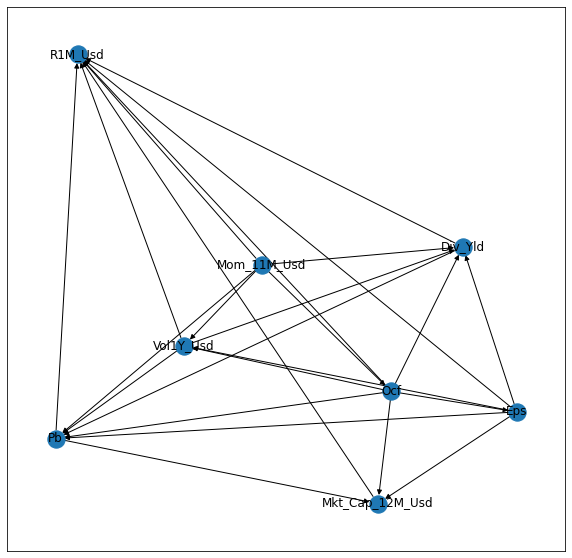

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw_networkx(graph_cam)
plt.show()

The matrix is not too sparse, which means that the model has uncovered many relationships between the variables within the sample. The Python implementation seems to give some different results from the original book (in which the target variable is not caused by any explanatory variables but has a reverse effect). The result above is satisfying.

For the sake of completeness, we also provide an implementation of python version of the `pcalg` package (Kalisch et al. (2012)) with `cdt`. Below, an estimation via the so-called PC (named after its authors **P**eter Spirtes and **C**lark Glymour) is performed. The details of the algorithm are out of the scope of the book, and the interested reader can have a look at section 5.4 of Spirtes et al. (2000) or section 2 from Kalisch et al. (2012) for more information on this subject.

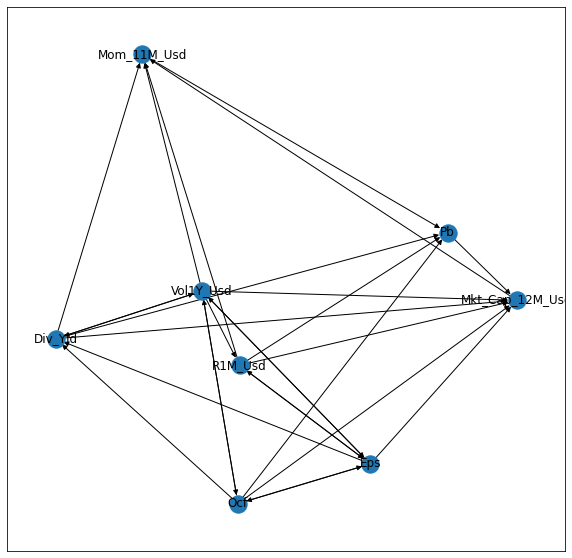

In [3]:
from cdt.causality.graph import PC

model_pc = PC(njobs=-1)
graph_pc = model_pc.predict(data_caus) # Time taken: 3.4s
fig = plt.figure(figsize=(10, 10))
nx.draw_networkx(graph_pc)
plt.show()

In [9]:
# Save the objects
# import pickle

# pickle.dump(graph_pc, open('./models/graph_pc.pkl', 'wb'))
# pickle.dump(graph_cam, open('./models/graph_cam.pkl', 'wb'))
# graph_pc_test = pickle.load(open('./models/graph_pc.pkl', 'rb'))

A bidirectional arrow is shown when the model was unable to determine the edge orientation. While the adjacency matrix is different compared to the first model, the `Eps` and `Vol1Y_Usd` seem to have a clear causal effect on the dependent variable.

### Structural Time Series Models

We end the topic of causality by mentioning a particular type of structural models: **structural time series**. Because we illustrate their relevance for a particular kind of causal inference, we closely follow the notations of Brodersen et al. (2015). The model is driven by two equations:
\begin{align*}
y_t&=\textbf{Z}_t'\boldsymbol{\alpha}_t+\epsilon_t \\
\boldsymbol{\alpha}_{t+1}& =\textbf{T}_t\boldsymbol{\alpha}_{t}+\textbf{R}_t\boldsymbol{\eta}_t.
\end{align*}
The dependent variable is expressed as a linear function of state variables $\boldsymbol{\alpha}_t$ plus an error term. These variables are in turn linear functions of their past values plus another error term which can have a complex structure (it's a product of a matrix $\boldsymbol{R}_t$ with a centered Gaussian term $\boldsymbol{\eta}_t$). This specification nests many models as special cases, like ARIMA for instance.

The goal of Brodersen et al. (2015) is to detect causal impacts via regime changes. They estimate the above model over a given training period and then predict the model’s response on some test set. If the aggregate (summed/integrated) error between the realized versus predicted values is significant (based on some statistical test), then the authors conclude that the breaking point is relevant. Originally, the aim of the approach is to quantify the effect of an intervention by looking at how a model trained before the intervention behaves after the intervention.

Below we test the $100^{th}$ date point in the sample (April 2008) is a turning point. Arguably, this date belongs to the time span of the subprime financial crisis. We use a Python version package `causalimpact`.

In [42]:
import causalimpact
from causalimpact import CausalImpact

stock1_data = data_ml[data_ml['stock_id'] == 1]
struct_data = stock1_data[['R1M_Usd'] + features_short]
pre_period = [0, 99]
post_period = [100, 199]
impact = CausalImpact(struct_data, pre_period, post_period)
impact.run()

In [43]:
impact.summary()

                                    Average           Cumulative
Actual                                    0                    1
Predicted                                 0                    0
95% CI                               [0, 0]            [-21, 21]
                                                                
Absolute Effect                           0                    1
95% CI                               [0, 0]            [23, -19]
                                                                
Relative Effect                     -593.9%              -593.9%
95% CI                  [-7055.4%, 5867.7%]  [-7055.4%, 5867.7%]
                                                                
P-value                               51.2%                     
Prob. of Causal Effect                48.8%                     


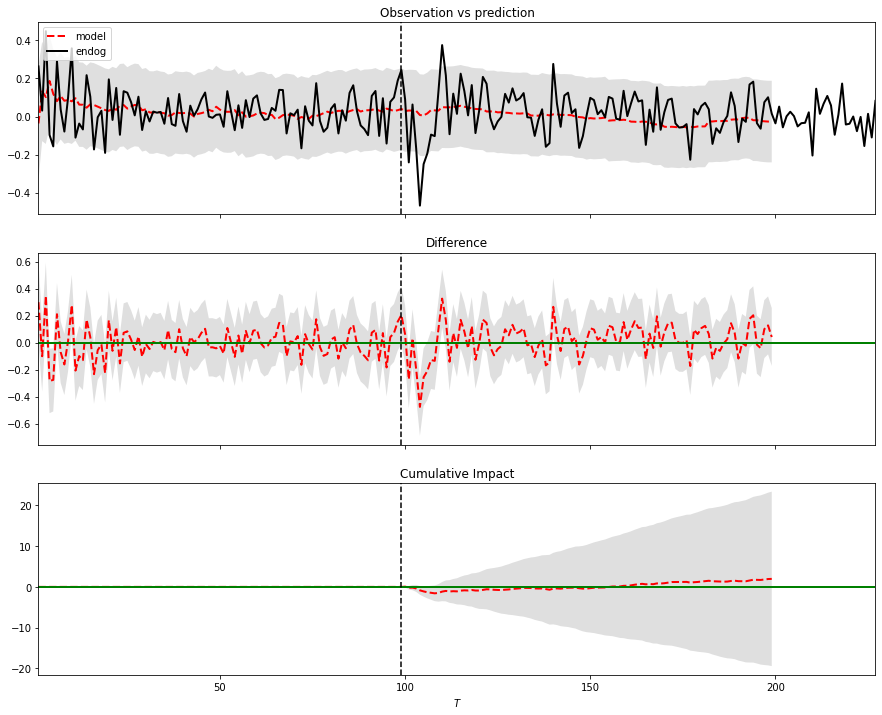

In [18]:
impact.plot()

Below, we make the report generated by the function (obtained by the commented line in the above code). The conclusions do not support a marked effect of the crisis on the model probably because the signs of the error in the post period constantly change sign.

In [24]:
impact.summary(output='report', width=150)

During the post-intervention period, the response             variable had an average value of             approx. 0.  In  the absence of an
intervention, we would have expected an average response of 0. The 95% interval of this counterfactual prediction is [0, 0]. Subtracting this
prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 0 with a
95% interval of [0, 0]. For a discussion of the significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response
variable had an overall value of 1.  Had  the intervention not taken place, we would have expected a sum of 0. The 95% interval of this prediction is
[-21, 21]


 The above results are given in terms of absolute numbers. In relative terms, the response variable showed  a decrease of  -593.9%. The 95% interval
of this percentage is [

## Dealing with Changing Environments

The most common assumption in machine learning contributions is that the samples that are studied are i.i.d. realizations of a phenomenon that we are trying to characterize. This constraint is natural because if the relationship between $X$ and $y$ always changes, then it is very hard to infer anything from observations. One major problem in Finance is that this is often the case: markets, behaviors, policies, etc., *evolve* all the time. This is at least partly related to the notion of absence of arbitrage: if a trading strategy worked all the time, all agents would eventually adopt it via herding, which would annihilate the corresponding gains. If the strategy is kept private, its holder would become infinitely rich, which obviously has never happened.

There are several ways to define changes in environments. If we denote with $\mathbb{P}_{XY}$ the multivariate distribution of all variables (features and label), with $\mathbb{P}_{XY}=\mathbb{P}_{X}\mathbb{P}_{Y|X}$, then two simple changes are possible:

- **Covariate shift**: $\mathbb{P}_{X}$ changes but $\mathbb{P}_{Y|X}$ does not: the features have a fluctuating distribution, but their relationship with $Y$ holds still;
- **Concept drift**: $\mathbb{P}_{Y|X}$ changes but $\mathbb{P}_{X}$ does not: feature distributions are stable, but their relation to $Y$ is altered.

Obviously, we omit the case when both items change, as it is too complex to handle. In factor investing, the feature engineering process (see Section 4.4) is partly designed to bypass the risk of covariate shift. Uniformization guarantees that the *marginals stay the same* but correlations between features may of course change. The main issue is probably concept drift when the way features explain the label changes through time. In Cornuejols, Miclet, and Barra (2018),31 the authors distinguish four types of drifts, which we reproduce in the following Figure 14.3. In factor models, changes are presumably a combination of all four types: they can be abrupt during crashes, but most of the time they are progressive (gradual or incremental) and never-ending (continuously recurring).

![FIGURE 14.3: Different flavors of concept change.](images/figure14-3.png)

Naturally, if we aknowledge that the environment changes, it appears logical to adapt models accordingly, i.e., dynamically. This gives rise to the so-called **stability-plasticity dilemma**. This dilemma is a trade-off between model **reactiveness** (new instances have an important impact on updates) versus **stability** (these instances may not be representative of a slower trend and they may thus shift the model in a suboptimal direction).

Practically,  there are two ways to shift the cursor with respect to this dilemma: alter the chronological depth of the training sample (e.g., go further back in time) or, allocate more weight to recent instances. We discuss the first option in Section 12.1 and the second mentioned in Section 6.3 (though the purpose in Adaboost is precisely to let the algorithm handle the weights). In neural networks, it is possible, in all generality to introduce instance-based weights in the computation of the loss function, though this option is not (yet) available in Keras (to the best of our knowledge: the framework evolves rapidly). For simple regressions, this idea is known as **weighted least squares** (WLS) wherein errors are weighted inside the loss:
$$L=\sum_{i=1}^I w_i(y_i-\boldsymbol{x}_i\boldsymbol{b})^2$$
In matrix terms, $L=(\textbf{y}-\textbf{Xb})'\textbf{W}(\textbf{y}-\textbf{Xb})$, where $\textbf{W}$ is a diagonal matrix of weights. The gradient with respect to $\textbf{b}$ is equal to $2\textbf{X}'\textbf{WX}\textbf{b}-2\textbf{X}'\textbf{Wy}$ so that the loss is minimized for $\textbf{b}^*=(\textbf{X}'\textbf{WX})^{-1}\textbf{X}'\textbf{Wy}$. The standard least-square solution is recovered for $\textbf{W}=\textbf{I}$. In order to fine-tune the reactiveness of the model, the weights must be a function that decreases as instances become older in the sample.

There is of course no perfect solution to changing financial environements. Below, we mention two routes that are taken in the ML literature to overcome the problem of non-stationarity in the data generating process. But first, we propose yet another clear verification that markets do experience time-varying distributions.

### Non-stationarity: yet another illustration

One of the most basic practices in (financial) econometrics is to work with *returns* (relative price changes). The simple reason is that returns seem to behave *consistently* through time (monthly returns are bounded, they usually lie between -1 and +1). Prices shift often and are harder to study.

Stationarity is a key notion in financial econometrics: it is much easier to characterize a phenomenon with distributional properties that remain the same through time (this makes them possible to capture). Sadly, the *distribution of returns is not stationary*: both the mean and the variance of returns change along cycles.

Below, we illustrate this fact by computing the average monthly return for all calendar years in the whole dataset.

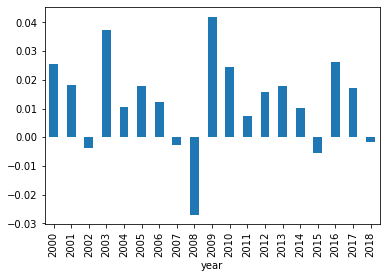

In [49]:
data_ml['year'] = data_ml['date'].apply(lambda x: x.year)
data_ml.groupby('year')['R1M_Usd'].mean().plot.bar()
plt.show()

These changes in the mean are also accompanied by variations in the second moment (variance / volatility). This effect, known as *volatility clustering*, has been widely documented ever since the theoretical breakthrough of Engle (1982). We refer for instance to Cont (2007) for more details on this topic. 

In terms of machine learning models, this is also true. Below, we estimate a pure characteristic regression with one predictor, the market capitalization averaged over the past 6-months ($r_{t+1,n}=\alpha+\beta x_{t,n}^{\text{cap}}+\epsilon_{t+1,n}$). The label is the 6-month forward return and the estimation is performed over every calendar year.

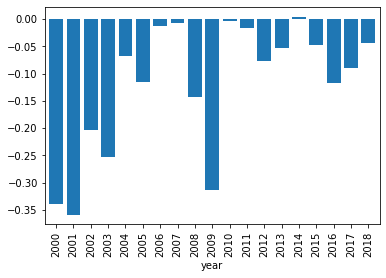

In [68]:
import statsmodels.api as sm

def get_beta(x):
    fit_lm = sm.OLS(x['R6M_Usd'], sm.add_constant(x['Mkt_Cap_6M_Usd'])).fit()
    return fit_lm.params[1]

data_ml.groupby('year').apply(get_beta).plot.bar(width=0.8)
plt.show()

The bars in Figure 14.5 highlight the concept drift: overall, the relationship between capitalization and returns is negative (the **size effect** again). Sometimes, it is markedly negative, sometimes, not so much. The ability of capitalization to explain returns is time-varying and models must adapt accordingly.

### Online Learning

Online learning refers to a subset of machine learning in which new information arrives progressively and the integration of this flow is performed iteratively (the term '*online*' is not linked to the Internet). In order to take the latest data updates into account, it is imperative to update the model (stating the obvious). This is clearly the case in finance and this topic is closely related to the discussion on learning windows in Section 12.1.

The problem is that for each year, the model will have to be re-trained with the whole dataset, which can be heavy. Including just the *latest* points in the learning process would substantially decrease the computationally cost. In neural networks, the sequential batch updating of weights can allow a progressive change in the model. Nonetheless, this is typically impossible for decision trees because the splits are decided once and for all.

The simplest example of online learning is the *Widrow-Hodd algorithm* (originally from Widrow and Hoff (1960)). Originally, the idea comes from the so-called *ADALINE* (ADAptive LInear NEuron) model which is a neural network with one hidden layer with linear activation function (i.e., like a perceptron, but with a different activation).

Suppose the model is linear $\textbf{y}=\textbf{Xb}+\textbf{e}$ and that the amount of data is both *massive* and coming in at a high frequency so that updating the model on the full sample is proscribed and technically intractable. A simple and heuristic way to update the values of b is to compute
$$\textbf{b}_{t+1} \longleftarrow \textbf{b}_t-\eta (\textbf{x}_t\textbf{b}-y_t)\textbf{x}_t'$$
where $\textbf{x}_t$ is the row vector of instance $t$. The justification is simple. The quadratic error $(\textbf{x}_t\textbf{b}-y_t)^2$ has a gradient w.r.t. $\textbf{b}$ equal to $2(\textbf{x}_t\textbf{b}-y_t)\textbf{x}_t'$; therefore, the above update is a simple example of gradient descent. $\eta$ must be of course quite small to avoid a volatile model.

An exhaustive review of techniques pertaining to online learning is presented in Hoi et al. (2018) (section 4.11 is even dedicated to portfolio selection). The book Hazan and others (2016) covers online convex optimization which is a very close domain with a large overlap with online learning. The presentation below is adapted from the second and third parts of the first survey.

Datasets are indexed by time: we write $\textbf{X}_t$ and $\textbf{y}_t$ for feature and labels. Time has a bounded horizon $T$. The machine learning model depends on some parameters $\boldsymbol{\theta}$ and we denote it with $f_{\boldsymbol{\theta}}$. At time $t$ (when dataset $(\textbf{X}_t, \textbf{y}_t)$ is gathered), the loss function $L$ of the trained model naturally depends on the data $(\textbf{X}_t, \textbf{y}_t)$ and on the model via $\boldsymbol{\theta}_t$ which are the parameter values fitted to the time-$t$ data. For notational simplicity, we henceforth write $L_t(\boldsymbol{\theta}_t)=L(\textbf{X}_t,\textbf{y}_t,\boldsymbol{\theta}_t)$. The key quantity in online learning is the regret over the whole time sequence:
$$R_T=\sum_{t=1}^TL_t(\boldsymbol{\theta}_t)-\underset{\boldsymbol{\theta}^*\in \boldsymbol{\Theta}}{\inf} \ \sum_{t=1}^TL_t(\boldsymbol{\theta}^*).$$
The regret is the total loss incurred by the models $\boldsymbol{\theta}_t$ minus the minimal loss that could have been obtained with full knowledge of the data sequence (hence computed in hindsight).

The basic methods in online learning are in fact quite similar to the batch-training of neural networks. The updating of the parameter is based on $$\textbf{z}_{t+1}=\boldsymbol{\theta}_t-\eta_t\nabla L_t(\boldsymbol{\theta}_t)$$
where $\nabla L_t(\boldsymbol{\theta}_t)$ denotes the gradient of the current loss $L_t$. One problem that can arise is when $\textbf{z}_{t+1}$ falls out of the bounds that are prescribed for $\boldsymbol{\theta}_t$. Thus, the candidate vector for the new parameters, $\textbf{z}_{t+1}$ is projected onto the feasible domain which we call $S$ here:
$$\boldsymbol{\theta}_{t+1}=\Pi_S(\textbf{z}_{t+1}), \quad \text{with} \quad \Pi_S(\textbf{u}) = \underset{\boldsymbol{\theta}\in S}{\text{argmin}} \ ||\boldsymbol{\theta}-\textbf{u}||_2$$
Hence $\boldsymbol{\theta}_{t+1}$ is as close as possible to the intermediate choice $\textbf{z}_{t+1}$. (a PGD algorithm?) In Hazan et al. (2007), it is shown that under suitable assumptions (e.g., $L_t$ being strictly convex with bounded gradient $\left|\left|\underset{\boldsymbol{\theta}}{\sup} \, \nabla L_t(\boldsymbol{\theta})\right|\right|\le G$), the regret $R_T$ satisfies
$$R_T \le \frac{G^2}{2H}(1+\log(T))$$
where $H$ is a scaling factor for the learning rate (also called step sizes): $\eta_t=(Ht)^{-1}$.

More sophisticated online algorithms generalize the previous algorithm by intergrating the Hessian matrix $\nabla^2 L_t(\boldsymbol{\theta}):=[\nabla^2 L_t]_{i,j}=\frac{\partial}{\partial \boldsymbol{\theta}_i \partial \boldsymbol{\theta}_j}L_t( \boldsymbol{\theta})$ and/or by including penalizations to reduce instability in $\boldsymbol{\theta}_t$. We refer to section 2 in Hoi et al. (2018) for more details on these extensions.

An interesting stream of parameter updating is that of the *passive-aggressive* algorithms (PAAs) formalized in Crammer et al. (2006). The base case involves classification tasks, but we stick to the regression setting below (section 5 in Crammer et al. (2006)). One strong limitation with PAAs is that they rely on the set of parameters where the loss is either zero or negligible: $\boldsymbol{\Theta}^*_\epsilon=\{\boldsymbol{\theta}, L_t(\boldsymbol{\theta})< \epsilon\}$. For general loss functions and learner $f$, this set is larly inaccessible. Thus, the algorithms in Crammer et al. (2006) are restricted to a particular case, namely linear $f$ and $\epsilon$-insensitive hinge loss:
$$L_\epsilon(\boldsymbol{\theta})=\left\{ \begin{array}{ll}
0 & \text{if } \ |\boldsymbol{\theta}'\textbf{x}-y|\le \epsilon \quad (\text{close enough prediction}) \\
|\boldsymbol{\theta}'\textbf{x}-y|- \epsilon & \text{if } \  |\boldsymbol{\theta}'\textbf{x}-y| >  \epsilon \quad (\text{prediction too far})
\end{array}\right.$$
for some parameter $\epsilon>0$. If the weight $\boldsymbol{\theta}$ is such that the model is close enough to the true value, then the loss is zero; if not, it is equal to the absolute value of the error minus $\epsilon$. In PAA, the update of the parameter is given by
$$\boldsymbol{\theta}_{t+1}= \underset{\boldsymbol{\theta}}{\text{argmin}} ||\boldsymbol{\theta}-\boldsymbol{\theta}_t||_2^2, \quad \text{subject to} \quad L_\epsilon(\boldsymbol{\theta})=0$$
hence the new parameter values are chosen such that two conditions are satisfied:

- The loss is zero (by the definition of the loss, this means that the model is close enough to the true value);
- and, the parameter is as close as possible to the previous parameter values.

By construction, if the model is good enough, the model does not move (passive phase), but if not, it is rapidly shifted towards values that yield satisfactory results (aggressive phase).

We end this section with a historical note. Some of the ideas from online learning stem from the financial literature and from the concept of **universal portfolios** originally coined by Cover (1991) in particular. The setting is the following. The function $f$ is assumed to be linear $f(\textbf{x}_t)=\boldsymbol{\theta}'\textbf{x}_t$ and the data $\textbf{x}_t$ consists of asset returns, thus the values are portfolio returns as long as $\boldsymbol{\theta}'\textbf{1}_N=1$ (the budget constraint). The loss functions $L_t$ correspond to a concave utility function (e.g., logarithmic) and the regret is reversed:
$$R_T=\underset{\boldsymbol{\theta}^*\in \boldsymbol{\Theta}}{\sup} \ \sum_{t=1}^TL_t(\textbf{r}_t'\boldsymbol{\theta}^*)-\sum_{t=1}^TL_t(\textbf{r}_t'\boldsymbol{\theta}_t)$$
where $\textbf{r}_t'$ are the returns. Thus, the program is transformed to maximize a concave function. Most contributions work with price data only, with the notable exception of Cover and Ordentlich (1996), which mentions external data ('*side information*'). In the latter article, it is proven that constantly rebalanced portfolios distributed according to two random distributions achieve growth rates that are close to the unattainable optimal rates. The two distributions are the uniform law (equally weighting, once again) and the Dirichlet distribution with constant parameters equal to 1/2. Under this universal distribution, Cover and Ordentlich (1996) show that the wealth obtained is bounded below by:
$$\text{wealth universal} \ge \frac{\text{wealth from optimal strategy}}{2(n+1)^{(m-1)/2}}$$
where $m$ is the number of assets and $n$ is the number of periods.

The literature on online portfolio allocation is reviewed in Li and Hoi (2014) and outlined in more details in Li and Hoi (2018). Online learning, combined to early stopping for neural networks, is applied to factor investing in Wong et al. (2020). Finally, online learning is associated to clustering methods for portfolio choice in Khedmati and Azin (2020).

### Homogeneous Transfer Learning

This subsection is mostly conceptual and will not be illustrated by coded applications. The ideas behind transfer learning can be valuable in that they can foster novel ideas, which is why we briefly present them below.

Suppose we are given two datasets $D_S$ (source) and $D_T$ (target). Each dataset has its own features $\textbf{X}^S$ and $\textbf{X}^T$ and labels $\textbf{y}^S$ and $\textbf{y}^T$. In classical supervised learning, the patterns of the target set are learned only through $\textbf{X}^T$ and $\textbf{y}^T$. Transfer learning proposes to improve the function $f^T$ (obtained by minimizing the fit $y_i^T=f^T(\textbf{x}_i^T)+\epsilon_i^T$ on the target data) via the function $f^S$ (from $y_i^S=f^S(\textbf{x}_i^S)+\epsilon_i^S$ on the source data). *Homogeneous* transfer learning is when the *feature space does not change*, which is the case in our setting. In asset management, this may not always be the case if for instance new predictors are included (e.g., based on alternative data like sentiment, satellite imagery, credit card logs, etc.).

There are many subcategories in transfer learning depending on what changes between the source $S$ and the target $T$: is it the feature space, the distribution of the labels, and/or the relationship between the two? These are the same questions as in Section 14.2. The latter case is of interest in finance because the link with non-stationarity is evident: it is when the model $f$ in $\textbf{y}=f(\textbf{X})$ changes through time. In transfer learning jargon, it is written as $P[\textbf{y}^S|\textbf{X}^S]\neq P[\textbf{y}^T|\textbf{X}^T]$: the conditional law of the label knowing the features is not the same when switching from the source to the target. Often, the term '*domain adaptation*' is used as synonym to transfer learning. Because of a data shift, we must adapt the model to increase its accuracy. These topics are reviewed in a series of chapters in the collection by Quionero-Candela et al. (2009).

An important and elegant result in the theory was proven by Ben-David et al. (2010) in the case of binary classification. We state it below. We consider $f$ and $h$ two classifiers with values in $\{0,1\}$. The average error between the two over the domain $S$ is defined by
$$\epsilon_S(f,h)=\mathbb{E}_S[|f(\textbf{x})-h(\textbf{x})|]$$
Then,
$$\epsilon_T(f_T,h)\le \epsilon_S(f_S,h)+\underbrace{2 \sup_B|P_S(B)-P_T(B)|}_{\text{ difference between domains }} + \underbrace{ \min\left(\mathbb{E}_S[|f_S(\textbf{x})-f_T(\textbf{x})|],\mathbb{E}_T[|f_S(\textbf{x})-f_T(\textbf{x})|]\right)}_{\text{difference between the two learning tasks}}$$
where $P_S$ and $P_T$ denote the distribution of the two domains. The above inequality is a bound on the generalization performance of $h$. If we take $f_S$ to be the best possible classifier for $S$ and $f_T$ the best for $T$, then the error generated by $h$ in $T$ is smaller than the sum of three components:

- The error in the $S$ space;
- The distance between the two domains (by how much the data space has shifted);
- The distance between the two best models (generators).

One solution that is often mentioned in transfer learning is instance weighting. We present it here in a general setting. In machine learning, we seek to minimize
$$\epsilon_T(f)=\mathbb{E}_T[L(y,f(\textbf{X}))]$$
where $L$ is some loss function. This can be arranged
\begin{align*}
\epsilon_T(f)&=\mathbb{E}_T \left[\frac{P_S(\textbf{y},\textbf{X})}{P_S(\textbf{y},\textbf{X})} L(\text{y},f(\textbf{X})) \right]  \\
&=\sum_{\textbf{y},\textbf{X}}P_T(\textbf{y},\textbf{X})\frac{P_S(\textbf{y},\textbf{X})}{P_S(\textbf{y},\textbf{X})} L(\text{y},f(\textbf{X})) \\
&=\mathbb{E}_S \left[\frac{P_T(\textbf{y},\textbf{X})}{P_S(\textbf{y},\textbf{X})} L(\text{y},f(\textbf{X})) \right]
\end{align*}
The key quantity is thus the transition ratio $\frac{P_T(\textbf{y},\textbf{X})}{P_S(\textbf{y},\textbf{X})}$ (*Radon-Nikodym derivative* under som eassumptions). Of course this ratio is largely inaccessible in practice, but it is possible to find a weighting scheme (over the instances) that yields improvements over the error in the target space. The weighting scheme, just as in Coqueret and Guida (2020), can be *binary*, thereby simply excluding some observations in the computation of the error. Simply *removing* observations from the training sample can have beneficial effects.

More generally, the above expression can be viewed as a theoretical *invitation* for user-specified *instance weighting* (as in Section 6.4.7). In the asset allocation parlance, this can be viewed as introducing views as to which observations are the most interesting, e.g., value stocks can be allowed to have a larger weight in the computation of the loss if the user believes they carry more relevant information. Naturally, it then always remains to minimize this loss.

We close this topic by mentioning a practical application of transfer learning developed in Koshiyama et al. (2020). The authors propose a neural network architecture that allows to share the learning process from different strategies across several markets. This method is, among other things, aimed at alleviating the backtest overfitting problem.

## Takeaways

- Causality
  - Most ML tools are designed for *correlations* instead of *causalities*
  - Granger causality: a linear (and statistical) form, no proof for causality
  - Causal additive models
    - Confounding factors
    - Structural Causal Model (**SCM**)
    - Directed acyclic graphs (**DAGs**)
    - CAM: additive of some non-linear models
    - PC model
  - Structural Time Series Models
    - A general form with state variables $\boldsymbol{\alpha}_t$
    - Regime changes and breaking points in time-series
- Non-stationarity
  - **Invariances** in CV and NLP are crucial, but the case is not likely for factor investing since the market is constantly *evolving*
  - **Covariate shift VS Concept drift**: we focus on the latter (relationship change)
  - **Stability-plasticity dilemma**: two solutions
    - Alter the chronological path of the training sample (Section 12.1)
    - Allow more weight to recent instances (Section 6.3), **weighted least squares** (WLS)
  - Non-stationarity: the distribution of returns is usually not stationary, implying model adaption
  - Online learning: including just the latest points in the learning process
    - Widrow-Hodd algorithm (and ADALINE): a simple gradient descent for a linear model
    - Online convex optimization: regret, PGD (projected gradient descent)
    - More sophisticated: Hessian matrix involved
    - Passive-aggressive algorithms (PAAs): a linear $f$ and $\epsilon$-insensitive hinge loss
    - Universal portfolios and wealth
    - Other applications: portfolio allocation, clustering, early stopping in NN
  - Homogeneous transfer learning: the feature space does not change
    - Interested: relationships between the features and the label are not the same when switching cases
    - Error in transfer learning in binary classification is smaller than the sum of 3 components.
    - One solution: instance weighting